# Amortized optimization

### Problem defintion

This problem and implementation are described in Meta tuorial about <a href="https://github.com/facebookresearch/amortized-optimization-tutorial">Amortized Optimization</a> and <a href="https://arxiv.org/abs/2202.00665">paper</a>.


The objective is to show how to use amortized optimization to learn to solve optimization problems over spheres of the form:

$y^*(x) \in \underset{{y \in S^2}}{\operatorname{argmin}} f(y;x)$

where 

$S^2$ is the surface of the unit 2-sphere embedded in $\mathbb{R}^3$ as $S^2 := \{y \in \mathbb{R}^3 | \lVert y \lVert_2 =1\}$ and

$x$ is some parameterization of the function $f : S^2 \times \mathcal{X} \rightarrow \mathbb{R} $.

Here the objective is to find the extreme values of a function defined on the Earth or other spaces that can be approximated with a sphere.

<b>Amortization objective</b> The orginal objective function needs to be transformed first from a constrained optimization problem into an unconstrained one using projection as follows:

$y^*(x) \in \underset{{y \in \mathbb{R}^3}}{\operatorname{argmin}} f(\pi_{S^2}(y);x)$


where $\pi_{S^2}: \mathbb{R}^3 \rightarrow S^2$ is is the Euclidean projection onto Celestial space

$\pi_{s^2}(x):= \underset{{y \in S^2}}{\operatorname{argmin}} \lVert y-x\lVert_2 = x/\lVert x \rVert_2$

<b>c-convex functions on the sphere</b>

$f(y;x)=min_\gamma \{\frac{1}{2} d(x,z_i) + \alpha_i\}^m_{i=1}$

where $m$ components define the context $x=\{z_i\} \cup \{\alpha_i\}$ with $z_i \in S^2$ and $\alpha_i \in \mathbb{R}$,

$d(x; y) := \arccos(x^T y)$ is the Riemannian distance on the sphere in the ambient Euclidean space Riemannian optimal transport replaces the standard Euclidean convex functions with socalled c-convex or c-concave functions, and the Euclidean translation by exponential map [<a href="Samuel Cohen, Brandon Amos, Yaron Lipman Proceedings of the 38th International Conference on Machine Learning, PMLR 139:2028-2038, 2021.">Ref.</a>].


$min_\gamma (a_1,...,a_m)=-\gamma log \sum_{i=1}^{m} \exp(-a_i/\gamma)$ is a soft minimization
operator

The context distribution $p(x)$ is sampled with $z_i \sim \mathcal{U}(S^2)$, i.e. uniformly from the sphere and $\alpha_i \sim \mathcal{N}(0; \beta)$ with variance $\beta \in \mathbb{R}_+$

<b><i>Note:</b></i> According to Encyclopida of Mathematics, A domain or compact subset $E$ in $C^n$ is said to be C-convex if for any complex line $l\subset C^n$ the intersection $E  \cap l$ is both connected and simply connected (meaning that its complement in the Riemann sphere $l\cap\{\infty\}$  is connected; cf. also Connected set; Simply-connected domain). 

In [1]:
import torch
from torch import nn
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('bmh')

In [2]:
# Convert from celestial coordinates to euclidean coordinates
def celestial_to_euclidean(ra, dec):
    x = np.cos(dec)*np.cos(ra)
    y = np.cos(dec)*np.sin(ra)
    z = np.sin(dec)
    return x, y, z

In [3]:
# Convert from celestial coordinates to euclidean coordinates
def euclidean_to_celestial(x, y, z):
    sindec = z
    cosdec = (x*x + y*y).sqrt()
    sinra = y / cosdec
    cosra = x / cosdec
    ra = torch.atan2(sinra, cosra)
    dec = torch.atan2(sindec, cosdec)
    return ra, dec

In [4]:
# Calculate the Riemannian distance between two points on the sphere
def sphere_dist(x,y):
    if x.ndim == 1:
        x = x.unsqueeze(0)
    if y.ndim == 1:
        y = y.unsqueeze(0)
    assert x.ndim == y.ndim == 2
    inner = (x*y).sum(-1)
    return torch.arccos(inner)

In [5]:
# Define a c-convex function
class c_convex(nn.Module):
    def __init__(self, n_components=4, gamma=0.5, seed=None):
        super().__init__()
        self.n_components = n_components
        self.gamma = gamma

        # Sample a random c-convex function
        if seed is not None:
            torch.manual_seed(seed)
        self.ys = torch.randn(n_components, 3)
        self.ys = self.ys / torch.norm(self.ys, 2, dim=-1, keepdim=True)
        self.alphas = .7*torch.rand(self.n_components)
        self.params = torch.cat((self.ys.view(-1), self.alphas.view(-1)))

    def forward(self, xyz):
        cs = []
        for y, alpha in zip(self.ys, self.alphas):
            ci = 0.5*sphere_dist(y, xyz)**2 + alpha
            cs.append(ci)
        cs = torch.stack(cs)
        if self.gamma == None or self.gamma == 0.:
            z = cs.min(dim=0).values
        else:
            z = -self.gamma*(-cs/self.gamma).logsumexp(dim=0)
        return z

### Sample a random c-convex function

In [6]:
seeds = [8,9,2,31,4,20,16,7]
fs = [c_convex(seed=i) for i in seeds]
n_params = len(fs[0].params)

### Define the base model

In [7]:
class AmortizedModel(nn.Module):
    def __init__(self, n_params):
        super().__init__()
        self.base = nn.Sequential(
            nn.Linear(n_params, n_hidden),
            nn.ReLU(inplace=True),
            nn.Linear(n_hidden, n_hidden),
            nn.ReLU(inplace=True),
            nn.Linear(n_hidden, 3)
        )

    def forward(self, p):
        squeeze = p.ndim == 1
        if squeeze:
            p = p.unsqueeze(0)
        assert p.ndim == 2
        z = self.base(p)
        z = z / z.norm(dim=-1, keepdim=True)
        if squeeze:
            z = z.squeeze(0)
        return z

### Define the model and optimizer

In [8]:
n_hidden = 128
torch.manual_seed(0)
model = AmortizedModel(n_params=n_params)
opt = torch.optim.Adam(model.parameters(), lr=5e-4)

### Train the model

In [9]:
from tqdm import tqdm
xs = []
num_iterations = 100

# Create tqdm progress bar
pbar = tqdm(range(num_iterations), desc="Training Progress")

for i in pbar:
    losses = []
    xis = []
    for f in fs:
        pred_opt = model(f.params)
        xis.append(pred_opt)
        losses.append(f(pred_opt))
    with torch.no_grad():
        xis = torch.stack(xis)
        xs.append(xis)
    loss = sum(losses)

    opt.zero_grad()
    loss.backward()
    opt.step()

    # Update progress bar description
    pbar.set_postfix({"Loss": loss.item()})

xs = torch.stack(xs, dim=1)

Training Progress: 100%|██████████| 100/100 [00:03<00:00, 32.13it/s, Loss=-.294]


### Plot the results

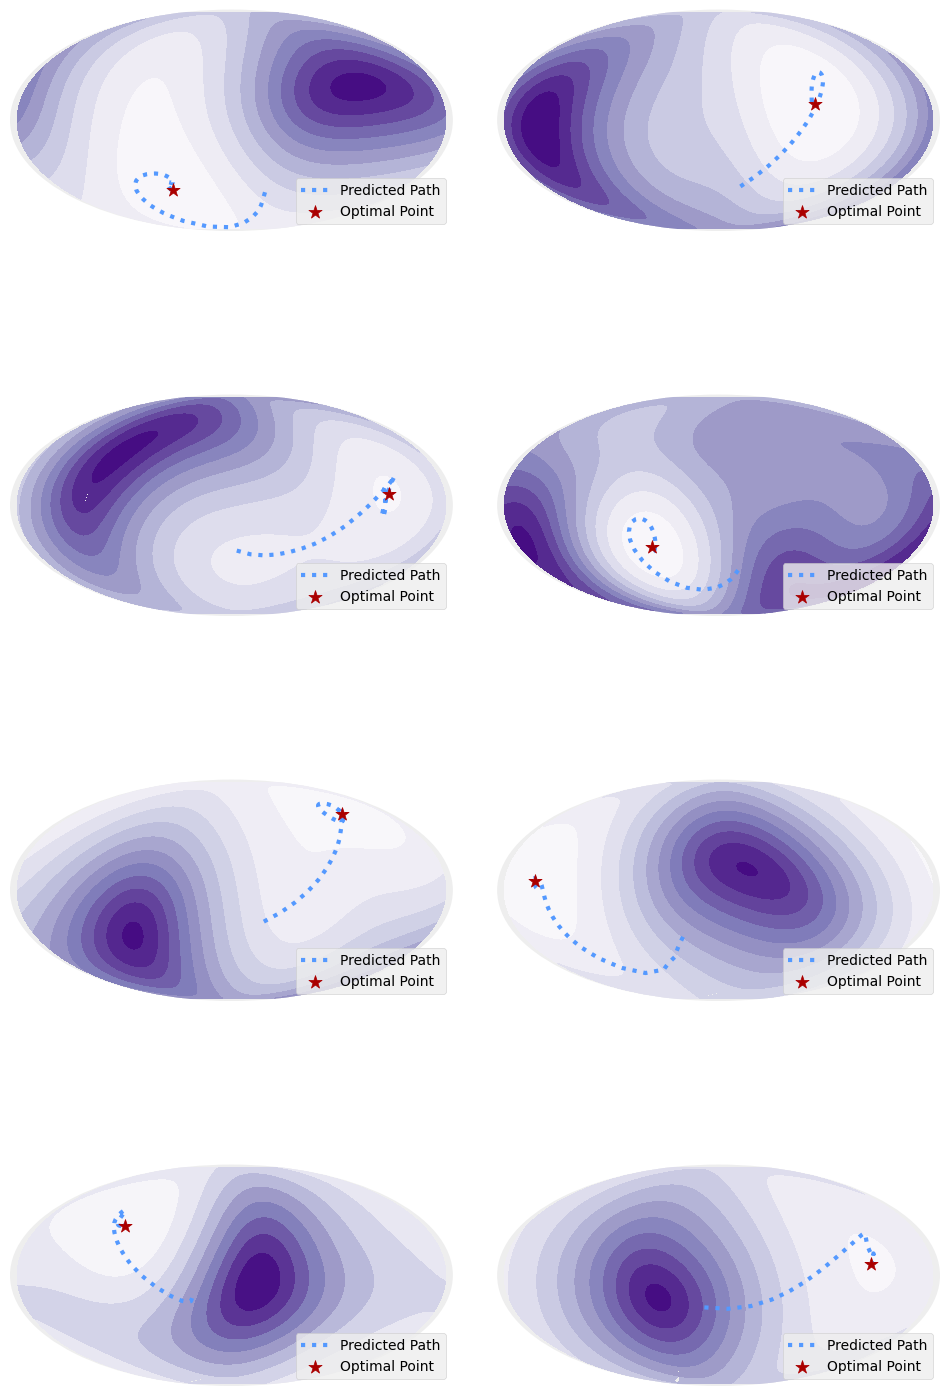

In [10]:
pad = .1
n_sample = 100
ra = np.linspace(-np.pi+pad, np.pi-pad, n_sample)
dec= np.linspace(-np.pi/2+pad, np.pi/2-pad, n_sample)
ra_grid, dec_grid = np.meshgrid(ra,dec)
ra_grid_flat = ra_grid.ravel()
dec_grid_flat = dec_grid.ravel()
x_grid, y_grid, z_grid = celestial_to_euclidean(ra_grid_flat, dec_grid_flat)

p_grid = np.stack((x_grid, y_grid, z_grid), axis=-1)
p_grid_th = torch.from_numpy(p_grid).float()

nrow, ncol = len(fs) // 2, 2
fig, axes = plt.subplots(
    nrow, ncol, figsize=(12, 5 * nrow),
    subplot_kw={'projection': 'mollweide'},
    gridspec_kw={'wspace': 0.1, 'hspace': 0}
)

# Reshape axes if there is only one row
if nrow == 1:
    axes = np.array([axes])

for i, (f, xs_i) in enumerate(zip(fs, xs)):
    row = i // ncol
    col = i % ncol
    ax = axes[row, col]

    with torch.no_grad():
        f_grid = f(p_grid_th).numpy()
    best_i = f_grid.argmin()
    ra_opt, dec_opt = ra_grid_flat[best_i], dec_grid_flat[best_i]

    f_grid = f_grid.reshape(ra_grid.shape)
    n_levels = 10
    contour = ax.contourf(ra_grid, dec_grid, f_grid, n_levels, cmap='Purples')

    x, y, z = xs_i.split(1, dim=-1)
    ra, dec = euclidean_to_celestial(x, y, z)
    line = ax.plot(ra, dec, color='#5499FF', lw=3, ls=':', label='Predicted Path')

    ax.scatter(ra_opt, dec_opt, marker='*', color='#AA0000',
               s=100, zorder=10, label='Optimal Point')

    # Add legend
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles, labels, loc='lower right')

    for s in ax.spines.values():
        s.set_visible(False)

    ax.set_xticks([])
    ax.set_yticks([])
    ax.grid(False)

    # print("Optimal value:", f_grid.min())
    # print("Predicted value:", f(xs_i)[0].item())

# Remove unused subplots
if len(fs) % 2 != 0:
    fig.delaxes(axes[-1, -1])

plt.show()